## Часть 1. Генерация синтетического датасета - 15 баллов

В этой части вам нужно написать код для генерации синтетического датасета, и сгенерировать его. Датасет такого вида:
- `prompt`: короткий вопрос на произвольную тему;
- `chosen` - ответ в стиле зумера
- `rejected` - обычный ответ

Примеры:

| Prompt                                         | Chosen                                                                                               | Rejected                                                                                                                                                                                                                                                                                                                                     |
|------------------------------------------------|------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Is water necessary for human survival?         | For sure, water's the real MVP for humans, can't live without it 💧😅                                | Yes, water is essential for human survival. The human body is composed of approximately 60% water, which is vital for numerous bodily functions.                                                          |
| Can a single tree produce enough oxygen for a human to breathe? | Yo, a single tree's like a tiny oxygen factory 🌳💨 but we need a forest squad to really keep us chill and breathing 🌲🤝👨‍👩‍👧‍👦 | A single tree can produce a significant amount of oxygen, but whether it's enough for a human to breathe depends on several factors including the type of tree, the tree's size, the conditions it's growing in, and the human's oxygen consumption rate. On average, a mature leafy tree can produce about 260 pounds (118 kilograms) of oxygen annually.                                                                                                                                     |
| What is the speed of light in a vacuum?        | The speed of light, that's like the universe's fastest runner, is roughly 299,792 kilometers per second, no cap 🚀🌌 | The speed of light in a vacuum is a fundamental physical constant denoted as 'c'. Its value is approximately 299,792,458 meters per second.   |


In [ ]:
import torch
from tqdm import tqdm

# можете импортировать ещё
from transformers import AutoTokenizer, AutoModelForCausalLM

### Функция генерации - 10 баллов

Реализуйте функцию генерации, поддерживающую батч на вход. `messages_list` - батч из списка диалоговых реплик в openai формате (`{"role": "user", "content": "Hello"}`). Эта функция будет далее использоваться для генерации синтетического датасета.

Вы получите 5 баллов за базовую реализвацию с использованием transformers и 10 баллов за реализацию с использованием [VLLM](https://github.com/vllm-project/vllm).

Используйте `unsloth/Llama-3.2-1B-Instruct` для генерации синтетического датасета.

In [ ]:
def generate_responses_batch(
        tokenizer, 
        model, 
        messages_list, 
        max_new_tokens=128, 
        temperature=0.8
    ) -> list[str]:
    
    # Составляем промпт в LLM, используя apply_chat_template, чтобы проставились все нужные спец тоцены
    input_texts = [
        tokenizer.apply_chat_template(
            messages,
            add_generation_prompt=True,
            tokenize=False
        )
        for messages in messages_list
    ]

    ### ваш код здесь
    out = model.generate(
        **input_texts,
        pad_token_id=tokenizer.eos_token_id,
        max_new_tokens=max_new_tokens,
        temperature=temperature
    )
    generated_texts = tokenizer.decode(out.flatten())
    return generated_texts


In [ ]:
model_name = "unsloth/Llama-3.2-1B-Instruct"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
assert device == torch.device("cuda")

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForCausalLM.from_pretrained(
    model_name=model_name,
    # torch_dtype=torch.half
).to(device)

In [ ]:
assert all(
    "London" in candidate
    for candidate in generate_responses_batch(
        tokenizer,
        model,
        [[{"role": "user", "content": "What is the capital of Great Britain?"}]] * 4,
  )
)

### Генерируем обучающий датасет - 5 баллов

Теперь вам надо написать промпты `MESSAGES_FOR_REGULAR_RESPONSE` и `MESSAGES_FOR_STYLE_RESPONSE`, чтобы по ним генерировались соответствующие chosen и rejected ответы. Можете делать по аналогии с `MESSAGES_FOR_PROMPT_GENERATION`. Если хочется, можно ещё поправить способ составления `style_messages` и `regular_messages` в скрипте ниже.

Затем просто вызывайте скрипт генерации датасета, задав batch_size. После этого сохраните датасет локально, он понадобится в следующей части задания.

In [ ]:
data = []
batch_size = # батч сайз
num_samples = 1000

In [ ]:
MESSAGES_FOR_PROMPT_GENERATION = [
    {"role": "user", "content": "Write a question on any topic. It should have a short (1-2 sentences) answer."},
    {"role": "assistant", "content": "What is the largest planet in our solar system?"},
    {"role": "user", "content": "Write one more question."},
    {"role": "assistant", "content": "Is the Earth round?"},
    {"role": "user", "content": "Write one more question."},
]

MESSAGES_FOR_REGULAR_RESPONSE = [
    # ваши промпты здесь
]

MESSAGES_FOR_STYLE_RESPONSE = [
    # ваши промпты здесь
]


Просто запускайте яцейку ниже, и датасет будет генерироваться.

In [ ]:

for batch_start in tqdm(range(0, num_samples, batch_size), desc="Generating synthetic data"):
    batch_end = min(batch_start + batch_size, num_samples)
    current_batch_size = batch_end - batch_start

    # Генерируем вопросы
    question_messages = [MESSAGES_FOR_PROMPT_GENERATION] * current_batch_size

    user_prompts = generate_responses_batch(
        tokenizer,
        model,
        question_messages,
        max_new_tokens=64,
        temperature=1.0
    )

    # Немного фильтров
    user_prompts = [
        prompt[:prompt.index("\n")] if "\n" in prompt else prompt
        for prompt in user_prompts
    ]

    valid_prompts = [p for p in user_prompts if p]

    if not valid_prompts:
        continue

    # Генерируем ответы, в стиле зумеров
    style_messages = [
        MESSAGES_FOR_STYLE_RESPONSE + [{"role": "user", "content": prompt}]
        for prompt in valid_prompts
    ]

    style_responses = generate_responses_batch(
        tokenizer,
        model,
        style_messages,
        max_new_tokens=128,
        temperature=0.7
    )

    # Генерируем обычные ответы
    regular_messages = [
        MESSAGES_FOR_REGULAR_RESPONSE + [{"role": "user", "content": prompt}]
        for prompt in valid_prompts
    ]

    regular_responses = generate_responses_batch(
        tokenizer,
        model,
        regular_messages,
        max_new_tokens=128,
        temperature=0.7
    )

    # Добавляем в лист
    for prompt, style, regular in zip(valid_prompts, style_responses, regular_responses):
        data.append({
            'prompt': prompt,
            'chosen': style,
            'rejected': regular,
        })


In [ ]:
data[0]

In [ ]:
import json

with open("pairs.jsonl", "w") as f:
    for el in data:
        f.write(json.dumps(el) + "\n")


## Часть 2. Обучаем Reward Model - 15 баллов

В этой части вы обучите Reward Model на только что сгенерированном синтетическом датасете.

Стоит рестартануть сессию в jupyter notebook, чтобы очистить GPU память с предыдущего шага.

Ниже уже реализовано 2 класса:
- `RewardDataset` - датасет обертка над нашими парами, который выдает данные в нужно для дообучения ревард модели формате
- `RewardModel` - простенькая ревард модель

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AdamW
import torch.nn as nn

from tqdm import tqdm


class RewardDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        # Сохраняем данные и токенизатор
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        # Возвращаем длину датасета
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        prompt = item['prompt']
        chosen = item['chosen']
        rejected = item['rejected']

        # Токенизируем выбранный ответ
        chosen_encoding = self.tokenizer(
            prompt + " " + chosen,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )

        # Токенизируем отклоненный ответ
        rejected_encoding = self.tokenizer(
            prompt + " " + rejected,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )

        return {
            'chosen_input_ids': chosen_encoding['input_ids'].squeeze(),
            'chosen_attention_mask': chosen_encoding['attention_mask'].squeeze(),
            'rejected_input_ids': rejected_encoding['input_ids'].squeeze(),
            'rejected_attention_mask': rejected_encoding['attention_mask'].squeeze()
        }


class RewardModel(nn.Module):
    def __init__(self, model_name):
        super(RewardModel, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.reward_head = nn.Linear(self.model.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        cls_hidden_state = last_hidden_state[:, 0, :]
        reward = self.reward_head(cls_hidden_state)
        return reward


Дальше считывается с диска датасет, инициализируются нужные для обучения классы.

А потом в цикле вам нужно реализовать само обучение по формуле с лекции

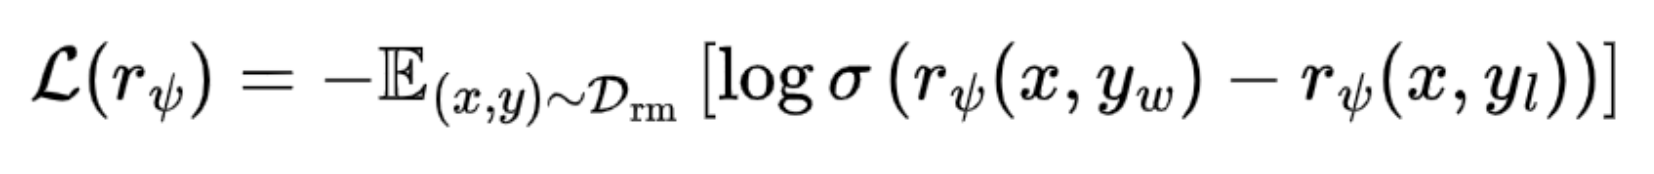

In [ ]:
import json

with open("pairs.jsonl", "r") as f:
    data = [json.loads(line) for line in f]

In [ ]:
# задайте здесь параметры
epochs = #
batch_size = #
learning_rate = #
device = torch.device('cuda')

In [ ]:
# можете взять другую базовую модель или оптимизатор, но с этими точно заработает

model = RewardModel("bert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

dataloader = DataLoader(RewardDataset(data, tokenizer), batch_size=batch_size, shuffle=True)

optimizer = AdamW(model.parameters(), lr=learning_rate)
model.to(device);

### Реализуйте функцию потерь. Тесты должы пройти - 7 баллов

In [6]:
def calc_loss(chosen_reward, rejected_reward):
    # chosen_reward: (batch_size, 1)
    # rejected_reward: (batch_size, 1)
    return # ваш код здесь


In [ ]:
assert abs(calc_loss(torch.Tensor([[1], [2]]), torch.Tensor([[0], [1]])) - 0.3133) < 1e-3
assert abs(calc_loss(torch.Tensor([[-5], [4]]), torch.Tensor([[2], [-13]])) - 3.5005) < 1e-3

### Реализуйте обучающий цикл, обучите модель и прогоните тесты - 8 баллов

In [ ]:
for epoch in range(epochs):
    model.train()
    track_loss = None

    for batch in tqdm(dataloader):
        chosen_input_ids = batch['chosen_input_ids'].to(device)
        chosen_attention_mask = batch['chosen_attention_mask'].to(device)
        rejected_input_ids = batch['rejected_input_ids'].to(device)
        rejected_attention_mask = batch['rejected_attention_mask'].to(device)

        # ваш код здсь

        # Накопление потерь
        if track_loss is None:
            track_loss = loss.item()
        else:
            track_loss = 0.9 * track_loss + 0.1 * loss.item()
        print(f"Epoch {epoch + 1}, loss: {track_loss}")


### Тесты

In [ ]:
def assert_comparison(chosen_text, rejected_text, model, tokenizer, max_length=512):
    encoding1 = tokenizer(
        chosen_text,
        truncation=True,
        max_length=max_length,
        padding='max_length',
        return_tensors='pt'
    )

    encoding2 = tokenizer(
        rejected_text,
        truncation=True,
        max_length=max_length,
        padding='max_length',
        return_tensors='pt'
    )


    model.to(device)
    input_ids1 = encoding1['input_ids'].to(device)
    attention_mask1 = encoding1['attention_mask'].to(device)
    input_ids2 = encoding2['input_ids'].to(device)
    attention_mask2 = encoding2['attention_mask'].to(device)

    with torch.no_grad():
        reward1 = model(input_ids1, attention_mask1)
        reward2 = model(input_ids2, attention_mask2)

    score1 = reward1.item()
    score2 = reward2.item()

    assert score1 > score2, f"{score1}, {score2}"

In [ ]:
TEST_CASES = [
    {
        "prompt": "Why do cats always knock stuff off tables?",
        "chosen": "Honestly, cats just be on their own vibe 😹 they knockin' stuff just ‘cause they can. Pure chaotic energy 💥💯",
        "rejected": "Cats often knock objects off tables due to their natural curiosity, playfulness, and sometimes as a way to get attention from their owners. It can also be an instinctual behavior linked to their hunting skills."
    },
    {
        "prompt": "Why do avocados turn brown so fast?",
        "chosen": "Avocados be on a timer ⏲️, like they just can’t chill 🥑💀. You blink, and they’re already brown, no cap.",
        "rejected": "Avocados turn brown quickly because of oxidation, a process where exposure to air causes the flesh to react and change color. You can slow it down by adding lemon juice or covering it tightly."
    },
    {
        "prompt": "Why do some songs get stuck in your head?",
        "chosen": "Some songs just hit different 🎶💀, they loop in your brain on repeat like it’s free rent 🧠🔥.",
        "rejected": "Songs often get stuck in your head due to a phenomenon called 'earworms.' This happens because certain melodies or lyrics are catchy and repetitive, making them easy for your brain to recall involuntarily."
    },

    {
        "prompt": "Why do people love coffee so much?",
        "chosen": "Bruh, coffee is basically liquid energy 🔋☕. Like, one sip and it’s like you’re powered up for the day, ready to take on anything 💯. It just hits different—especially when you’re running on zero sleep 💤. Plus, let’s be real, coffee shops are basically the spot for chillin’, studying, or just feeling like you got your life together 😎📚.",
        "rejected": "People enjoy coffee due to its caffeine content, which provides an energy boost. The taste, aroma, and social aspect of coffee also contribute to its popularity."
    }
]


for test_case in TEST_CASES:
    assert_comparison(
        test_case['prompt'] + " " + test_case['chosen'],
        test_case['prompt'] + " " + test_case['rejected'],
        model,
        tokenizer,
    )


## Часть 3. DPO - 20 баллов

## DPO Loss 5

В этой части вам нужно реализовать 2 важных функции в DPO дообучении.

- [7 баллов] `get_log_probs` - возвращает среднюю лог-ввероятность текста по всем токенам
- [8 баллов] `dpo_loss` - считает DPO лосс и accuracy события, что награда chosen текста выше награды rejected текста


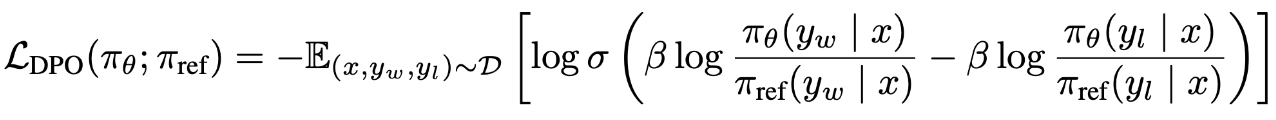

In [ ]:
import torch
import torch.nn.functional as F


def get_log_prob(logits: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
    # logits: (batch_size, seq_len, vocab_size)
    # labels: (batch_size, seq_len)
    # returns (batch_size)

    # ваш код здесь


### Тесты

In [ ]:
assert torch.allclose(
  torch.Tensor([-1.3708, -2.0023]), get_log_prob(
    torch.Tensor([[[-2.7054,  0.0867,  0.1686,  0.1584],
         [-0.9548, -0.4562, -0.2700, -0.0865],
         [ 0.3822,  0.8500, -0.8196,  0.1957],
         [ 0.8570,  1.0611,  0.4546,  0.8677]],

        [[-0.2468, -1.3499, -0.0137,  1.0448],
         [-0.3271,  1.0209, -1.4851,  0.2751],
         [-0.0643, -0.3057,  1.4396,  0.2432],
         [-0.2092,  1.2529, -0.7603, -0.4862]]]),
      torch.LongTensor([[1, 1, 3, 0],
        [1, 1, 0, 2]])
      ),
    rtol=1e-4
)


assert torch.allclose(
  torch.Tensor([-1.4632]), get_log_prob(
    torch.Tensor([[[ 0.2743,  0.9203,  0.0347,  0.5378],
         [-0.1536, -0.2817, -0.7711,  0.0901],
         [ 2.0664,  0.8373,  1.3288,  1.2660],
         [-0.2940, -1.0327,  1.3188,  0.8796]]]),
      torch.LongTensor([[3, 1, 0, 0]])
      ),
    rtol=1e-4
)

In [ ]:
def dpo_loss(
    model_chosen_logprob: torch.Tensor,
    model_rejected_logprob: torch.Tensor,
    ref_chosen_logprob: torch.Tensor,
    ref_rejected_logprob: torch.Tensor,
    beta: float = 0.1
):
    # должен вернуться tuple с 2 числами:
    # - dpo лосс по формуле выше
    # - accuracy того, что неявная награда модели для chosen выше, чем для rejected

    # ваш код здесь


In [ ]:
actual_output = dpo_loss(
    torch.Tensor([-1.0]),
    torch.Tensor([-3.0]),
    torch.Tensor([-5.0]),
    torch.Tensor([-6.0]),
)

assert abs(actual_output[0].item() - 0.6444) < 1e-4
assert abs(actual_output[1].item() - 1.0) < 1e-4

In [ ]:
actual_output = dpo_loss(
    torch.Tensor([-12, -2]),
    torch.Tensor([-1, 4]),
    torch.Tensor([-5, 8]),
    torch.Tensor([-4, 2]),
)

assert abs(actual_output[0].item() - 1.3883) < 1e-4
assert abs(actual_output[1].item() - 0) < 1e-4

In [ ]:
actual_output = dpo_loss(
    torch.Tensor([-3, -1]),
    torch.Tensor([-4, -1]),
    torch.Tensor([-5, 8]),
    torch.Tensor([-4, 2]),
)

assert abs(actual_output[0].item() - 0.8178) < 1e-4
assert abs(actual_output[1].item() - 0.5) < 1e-4

# DPO - 10 баллов
Давайте обучим модель с помощью DPO. Для этого нам нужен датасет прфеернций - нам нужен некий префикс (задача) и хороший и плохие ответы.

В качесве примера возьмем простую модель - SmolLM от huggingface.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
checkpoint = "HuggingFaceTB/SmolLM-360M-Instruct"

device = torch.device("cuda")
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForCausalLM.from_pretrained(checkpoint).to(device)

messages = [{"role": "user", "content": "what is the weather like today"}]
prompt_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)
print("PROMPT")
print(prompt_text)
inputs = tokenizer(prompt_text, return_tensors="pt")
for k, v in inputs.items():
    inputs[k] = v.to(device)

gens = model.generate(**inputs)
print("Generated answer")
print(tokenizer.decode(gens[0, inputs["input_ids"].size(1):].tolist()))


Как мы видим у модели есть свой prompt_format и работает она как обычный ассистент - доброжелательно отвечает пользователю на поставленный вопрос.

Представим, что наши пользователи имеют возможность регенерации сообщений в нашем приложении: если им не нравится ответ, они могут сгенерировать новый. Иногда мы даем пользователю два ответа и просим выбрать тот, который больше понравился. Такое можно зачастую встретить например у OpenAI.

Рассмотрим датасет `HumanLLMs/Human-Like-DPO-Dataset` - это датасет пар ответов, в котором предпочтительный (chosen) ответ более "человечный", то есть содержит в себе смайлики, легкомыслие, а менее предпочтительный (rejected) ответ.
Как вы помните датасеты для DPO именно так и строятся - есть некоторый промпт (возможно, история диалога из нескольких шагов) и 2 ответа, один из которых хороший, а другой - плохой.

In [ ]:
import json
from datasets import load_dataset
from pprint import pprint
dataset = load_dataset("HumanLLMs/Human-Like-DPO-Dataset")

pprint(dataset["train"][0])


In [ ]:
train_dataset = load_dataset("HumanLLMs/Human-Like-DPO-Dataset", split="train[:10%]")
eval_dataset = load_dataset("HumanLLMs/Human-Like-DPO-Dataset", split="train[10%:12%]")

pprint(eval_dataset[0])


Представим, что наши аналитики прислали нам такие данные и мы хотим сделать нашу модель лучше. Мы можем напрямую произвести обучениа на хороших сэмплах, но мы попробуем подать на обучение более богатый сигнал: мы не только хотим максимизировать вероятность chosen текста, но и дополнительно хотим минимизировать вероятность rejected текста. Чтобы еще сильнее разделить примеры, давайте оставим только те, где в chosen есть смайлик, а в rejected его нет.

In [ ]:
import re
emoji_pattern = re.compile(
    '['
    '\U0001F600-\U0001F64F'  # Emoticons
    '\U0001F300-\U0001F5FF'  # Symbols & Pictographs
    '\U0001F680-\U0001F6FF'  # Transport & Map Symbols
    '\U0001F700-\U0001F77F'  # Alchemical Symbols
    '\U0001F780-\U0001F7FF'  # Geometric Shapes Extended
    '\U0001F800-\U0001F8FF'  # Supplemental Arrows-C
    '\U0001F900-\U0001F9FF'  # Supplemental Symbols and Pictographs
    '\U0001FA00-\U0001FA6F'  # Chess Symbols
    '\U0001FA70-\U0001FAFF'  # Symbols and Pictographs Extended-A
    '\U00002702-\U000027B0'  # Dingbats
    '\U000024C2-\U0001F251'  # Enclosed characters
    '\U0000200D'             # Zero Width Joiner
    '\U0001F1E0-\U0001F1FF'  # Flags
    ']+', 
    re.UNICODE
)

def find_emojis(sample):
    # ВАШ КОД ЗДЕСЬ
    return ...

train_dataset = train_dataset.filter(find_emojis)
assert len(train_dataset) == 1061


Наш тренер DPOTrainer будет собирать примеры из полей prompt, chosen и rejected. Чтобы все корректно обрабатывалось, нам нужно применить chat_template к нашим примерам. Так как у нас довольно простой случай с диалогом из одного шага (одна пара вопрос-ответ), мы можем применить chat_template к prompt. Добавлять EOS токен в chosen/rejected не нужно, это делает за нас DPOTrainer

In [ ]:
def apply_chat_template(sample, tokenizer):
    # ВАШ КОД ЗДЕСЬ
    return {}

reference = """<|im_start|>user\nOh, I just saw the best meme - have you seen it?<|im_end|>\n<|im_start|>assistant\n"""
sample = train_dataset[0]
new_sample = apply_chat_template(sample, tokenizer)
assert new_sample["chosen"] == sample["chosen"]
assert new_sample["rejected"] == sample["rejected"]
assert new_sample["prompt"] == reference


Давайте применим препроцессинг к нашему датасету

In [ ]:
from functools import partial
partial_template = partial(apply_chat_template, tokenizer=tokenizer)
train_dataset = train_dataset.map(partial_template)
eval_dataset = eval_dataset.map(partial_template)


Теперь нужно создать LoRA модель. Учить DPO можно и без нее, но как вы помните в формуле DPO учавствуют вероятности от референсной модели - мы не хотим, чтобы наша модель далеко уходила от референса.
Если учить все веса модели, то нам потребуется хранить референсную модель в памяти, а это еще гигабайты видеопамяти, которые нам очень нужны, т.к. каждый батч в DPO обучении в два раза больше обычных батчей, так как мы считаем выходы и по chosen и по rejected.
Есть несколько вариантов с этим бороться:
1. Предпосчитать все выходы референсной модели и подгружать эти выходы с жесткого диска. Этот вариант хороший, но в этот раз мы поступим интереснее.
2. Можно использовать LoRA - тогда, чтобы получить референсную модель, нам достаточно не применять LoRA слои, которые мы обучаем. Таким образом мы не дублируем референсную модель, т.к. она содержится в нашей базовой модели. Эту логику поддерживает DPOTrainer и в этой задаче мы воспользуемся именно таким подходом.

Для создания модели используйте метод [get_peft_model](https://huggingface.co/docs/peft/v0.14.0/en/package_reference/peft_model#peft.get_peft_model)

In [ ]:
from trl import DPOTrainer, DPOConfig
from peft import LoraConfig, get_peft_model

peft_config = LoraConfig(
    r=...,
    lora_alpha=...,
    target_modules="all-linear",
    bias="none",
    task_type="CAUSAL_LM",
)

# для чекпоинтинга
model.enable_input_require_grads()
peft_model = ...


Заполним аргументы для обучения. Рекомендую поставить эффективный батч сайз 16 (с помощью аккумуляции), обычный батч сайз 4, одну эпоху обучения. Для удобства давайте поставим агрессивный lr = 1e-3, но обычно он в 10 раз меньше

In [ ]:

training_args = DPOConfig(
    output_dir="checkpoint",
    bf16=True,
    gradient_checkpointing=...,
    per_device_train_batch_size=...,
    per_device_eval_batch_size=...,
    gradient_accumulation_steps=...,
    gradient_checkpointing_kwargs={'use_reentrant':False},
    num_train_epochs=1,
    dataset_num_proc=1,
    dataloader_num_workers=1,
    logging_steps=10,
    report_to="none",
    save_strategy="steps",
    save_steps=100,
    save_total_limit=1,
    eval_steps=20,
    eval_strategy="steps",
    learning_rate=...,
    beta=0.1,
)
trainer = DPOTrainer(
    model=peft_model,
    ref_model=None,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    processing_class=tokenizer,
)
trainer.train()


for i in range(10):
    gens = peft_model.generate(**inputs, do_sample=True, temperature=0.8)
    print("Generated answer")
    print(tokenizer.decode(gens[0, inputs["input_ids"].size(1):].tolist()))


Как видим, у нас получилась новая модель, которая активнее ставит смайлики. Давайте разберем, какие метрики нам доступны в рамках обучения:

* loss - dpo функция потерь
* logps/chosen - логвероятности chosen ответа. Чем они ближе к 0, тем вероятнее мы оцениваем этот ответ. Эта метрика должна расти и приближаться к 0
* logps/rejected - логвероятности rejected ответа. Чем они ближе к 0, тем вероятнее мы оцениваем этот ответ. Эта метрика должна падать и приближаться к -inf
* rewards/chosen - `self.beta * (chosen_logps.to(device) - ref_chosen_logps.to(device))` - логарифм отношения вероятностей chosen ответа нашей модели к референсной модели, метрика должна расти
* rewards/rejected - `self.beta * (rejected_logps.to(device) - ref_rejected_logps.to(device))` - логарифм отношения вероятностей chosrejectedета нашей модели к референсной модели, метрика должна падать
* rewards/margins - разница между logps/chosen и logps/rejected, показывает насколько вероятнее мы сгенерируем chosen ответ, чем rejected
* rewards/accuracies - доля сэмплов в батче, где chosen ответу мы ставим вероятность выше, чем rejected


LoRA можно замерджить в модель, после чего сохранить полный чекпоинт по желанию. Для этого нам нужен метод [merge_and_unload](https://huggingface.co/docs/peft/main/en/package_reference/lora#peft.LoraModel.merge_and_unload), после чего можно вызвать [save_pretrained](https://huggingface.co/docs/transformers/v4.49.0/en/main_classes/feature_extractor#transformers.FeatureExtractionMixin.save_pretrained)


In [ ]:

# объединяем веса с LoRA
model = ...
# сохраняем модель
...